In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import librosa
import numpy as np
import IPython.display as ipd
from glob import glob
import matplotlib.pyplot as plt
import tensorflow
tensorflow.config.run_functions_eagerly(True)
from tensorflow import keras
%matplotlib inline

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/DATA_SCIENCE_PROJECTS/Urban_Sound_Classification/train.csv")
df_train.head()

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


In [5]:
df_train.shape

(5435, 2)

In [6]:
df_train.isnull().sum()

ID       0
Class    0
dtype: int64

In [7]:
np.unique(df_train['Class'])

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [8]:
# to load an audio file into an audio array. Return both the audio array as well as the sample rate

data, sampling_rate = librosa.load('/content/drive/MyDrive/DATA_SCIENCE_PROJECTS/Urban_Sound_Classification/Train/1.wav')

In [9]:
# Display the length of the audio array and sample rate

print('Shape is {}, Sample Rate is {}'.format(data.shape, sampling_rate))
print('Data Type is {}'.format(data.dtype))

Shape is (88200,), Sample Rate is 22050
Data Type is float32


In [10]:
# PLAYING SAMPLE AUDIO

ipd.Audio(data, rate=sampling_rate)

# VISUALIZE(EDA)

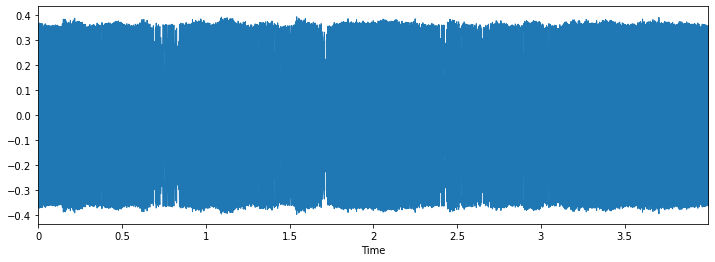

In [11]:
# PLOTTING THE AUDIO ARRAY

import librosa.display
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

Class :  street_music


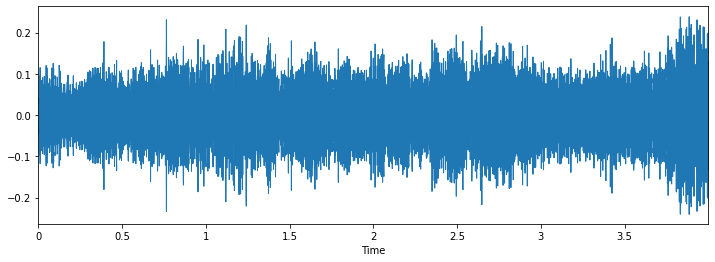

In [12]:
import random
index = random.choice(df_train.index)

print("Class : ", df_train['Class'][index])
data, sampling_rate = librosa.load('/content/drive/MyDrive/DATA_SCIENCE_PROJECTS/Urban_Sound_Classification/Train/'+str(df_train['ID'][index])+'.wav')

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

Class :  street_music


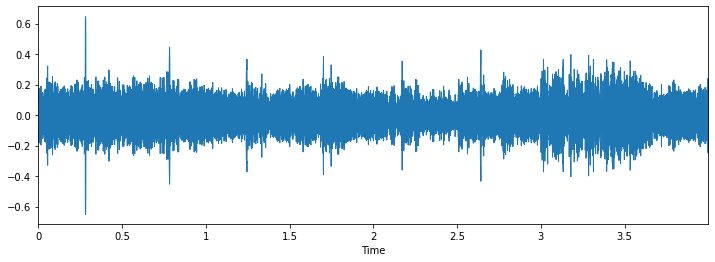

In [13]:
import random
index = random.choice(df_train.index)

print("Class : ", df_train['Class'][index])
data, sampling_rate = librosa.load('/content/drive/MyDrive/DATA_SCIENCE_PROJECTS/Urban_Sound_Classification/Train/'+str(df_train['ID'][index])+'.wav')

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


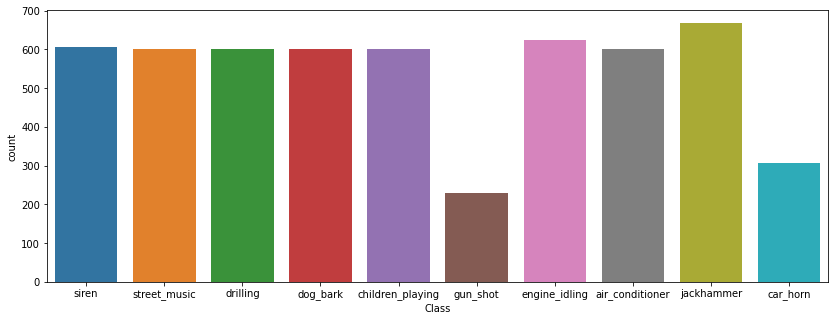

In [14]:
import seaborn as sns
plt.figure(figsize=(14,5))
sns.countplot(df_train['Class'])

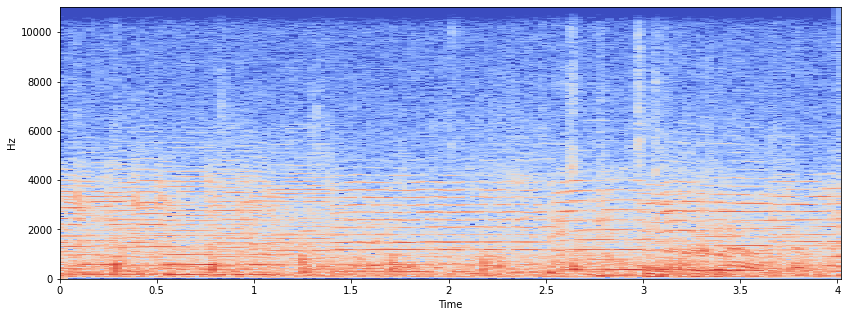

In [15]:
# DISPLAYING SPECTROGRAM

X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')

# INPUT SPLIT

In [16]:
def parser(row):
    # path of the file
    file_name = os.path.join('/content/drive/MyDrive/DATA_SCIENCE_PROJECTS/Urban_Sound_Classification/Train/'+ str(row['ID'])+ '.wav')
    # load the audio file
    x, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    # extract features from the data
    mfccs = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40).T, axis=0) # T - Transpose the extracted features
    
    feature = mfccs
    label = row['Class'] # OR row.Class
    
    return [feature, label]

In [17]:
data = df_train.apply(parser, axis=1)
data.columns = ['feature', 'label']

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [18]:
data.head()

0    [[-82.12359, 139.50592, -42.430866, 24.82786, ...
1    [[-15.744005, 124.119965, -29.42888, 39.447193...
2    [[-123.393654, 15.181946, -50.09333, 7.1418734...
3    [[-213.27881, 89.323586, -55.256187, 12.632097...
4    [[-237.92648, 135.90245, 39.26844, 21.24024, 9...
dtype: object

In [19]:
data[0]

[array([-82.12359   , 139.50592   , -42.430866  ,  24.82786   ,
        -11.620764  ,  23.497084  , -12.19459   ,  25.897139  ,
         -9.405277  ,  21.21043   ,  -7.3688216 ,  14.254338  ,
         -8.6786995 ,   7.7502384 , -10.124115  ,   3.258119  ,
        -11.352619  ,   2.8009686 ,  -7.0460134 ,   3.9133134 ,
         -2.3349748 ,   2.0124226 ,  -2.793944  ,   4.1292744 ,
         -1.6207688 ,   4.3262014 ,  -1.0344098 ,  -1.2329768 ,
         -3.1108537 ,   0.3204486 ,  -1.7877866 ,   0.44295514,
         -1.7916478 ,  -0.76361805,  -1.2424643 ,  -0.27664027,
          0.65718526,  -0.5023713 ,  -2.6042857 ,  -1.0534623 ],
       dtype=float32), 'siren']

In [20]:
# input split

x = np.array(list(zip(*data))[0])
y = np.array(list(zip(*data))[1])

# LABEL ENCODER

In [21]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils 

le = LabelEncoder()
y = np_utils.to_categorical(le.fit_transform(y))

In [22]:
y.shape

(5435, 10)

In [23]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

# CREATING MODEL

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

num_classes = 10

model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

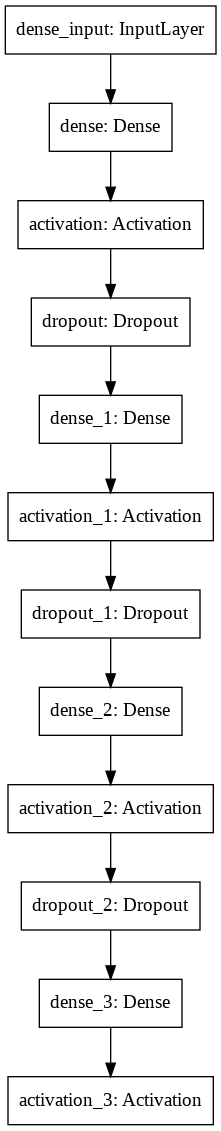

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='Urban_Sound_Model.png')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [27]:
# train the model
model.fit(x, y, batch_size=32, epochs=100, validation_split=0.25)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/100
128/128 [==============================] - 5s 19ms/step - loss: 9.8120 - accuracy: 0.1560 - val_loss: 2.1409 - val_accuracy: 0.1972
Epoch 2/100
128/128 [==============================] - 2s 17ms/step - loss: 2.1470 - accuracy: 0.2385 - val_loss: 1.8552 - val_accuracy: 0.3694
Epoch 3/100
128/128 [==============================] - 2s 18ms/step - loss: 1.9606 - accuracy: 0.3067 - val_loss: 1.7414 - val_accuracy: 0.4209
Epoch 4/100
128/128 [==============================] - 2s 17ms/step - loss: 1.8009 - accuracy: 0.3540 - val_loss: 1.5547 - val_accuracy: 0.4533
Epoch 5/100
128/128 [==============================] - 2s 17ms/step - loss: 1.6325 - accuracy: 0.4139 - val_loss: 1.4068 - val_accuracy: 0.5247
Epoch 6/100
128/128 [==============================] - 2s 17ms/step - loss: 1.5194 - accuracy: 0.4604 - val_loss: 1.2982 - val_accuracy: 0.5666
Epoch 7/100
128/128 [==============================] - 2s 17ms/step - loss: 1.4089 - accuracy: 0.5105 - val_loss: 1.2100 - val_accuracy:

In [28]:
model.save('Urban_Sound_Classification_model.h5')